In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split, dianostic_plots, pad_for_detector
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla K80


In [45]:
data_x = pickle.load(open('../../../../temp/buffers/ss_samples/train_x.data', 'rb'))
data_y = pickle.load(open('../../../../temp/buffers/ss_samples/train_y.data', 'rb'))
train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)
train_x, val_x = pad_for_detector(train_x, 10), pad_for_detector(val_x, 10)

5016 (4013, 1000, 4) (4013,) (1003, 1000, 4) (1003,)


In [46]:
train_x, val_x = torch.from_numpy(train_x).float(), torch.from_numpy(val_x).float()
train_y, val_y = torch.from_numpy(train_y).float(), torch.from_numpy(val_y).float()

# Convert data format from channel_last to channer_first
N, L, C = train_x.shape
n, l, _ = val_x.shape
train_x = train_x.reshape(N, C, L).to(device)
val_x = val_x.reshape(n, C, l).to(device)

train_y = train_y.to(device)
val_y = val_y.to(device)

# Generate dataset for data loader
train_dataset = data.TensorDataset(train_x, train_y)
val_dataset = data.TensorDataset(val_x, val_y)

In [47]:
# Reference for connecting Conv1D and LSTM: https://mxnet.incubator.apache.org/versions/master/tutorials/basic/reshape_transpose.html
class HybridNet(nn.Module):
    
    def __init__(self, pesudo_input, num_filters, filter_size, rnn_size, fc_out, dp1, dp2, 
                 num_rnn_layers=1, rnn_dropout=0):
        super(HybridNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=num_filters, kernel_size=filter_size)
        out = self.conv1(pesudo_input)
        out = nn.MaxPool1d(kernel_size=5, stride=5)(out)
        ####################################################
        print('shape after conv1d {}'.format(out.shape))
        N, C, T = out.shape
        out = torch.transpose(out, 1, 2)
        print('shape before lstm {}'.format(out.shape))
        ####################################################
        # or input_size*seq_len
        self.bi_lstm = nn.LSTM(input_size=C, hidden_size=rnn_size, num_layers=num_rnn_layers,
                              batch_first=True, dropout=rnn_dropout, bidirectional=True)
        out, _ = self.bi_lstm(out)
        print('shape after lstm {}'.format(out.shape))
        N, T, C = out.shape
        #out = torch.transpose(out, 1, 2)
        out = out.reshape(N, -1)
        print('shape after flattening {}'.format(out.shape))
        self.fc1 = nn.Linear(T*C, fc_out, bias=True)
        self.fc2 = nn.Linear(fc_out, 1)
        self.p1 = dp1
        self.p2 = dp2
        
    def forward(self, seq):
        self.activation_seq = F.relu(self.conv1(seq))
        out = nn.MaxPool1d(kernel_size=5, stride=5)(self.activation_seq)
        out = nn.Dropout(p=self.p1)(out)
        
        #################################################################################
        # Input of LSTM layer should have shape (sequence_length, batch_size, input_size)
        #     - Sequence length here should be the length of activation after downsampling
        #     - Input size should be the number of filters
        #################################################################################
        N, C, T = out.shape
#         out = out.view(bs, 1, -1)
        out = torch.transpose(out, 1, 2)
        out, _ = self.bi_lstm(out)
        out = F.relu(out)
        
        #################################################################################
        # Need to flatten the sequence before feeding them into fully connected layer
        #################################################################################
        N, T, C = out.shape
        #out = torch.transpose(out, 1, 2)
        out = out.reshape(N, -1)
        out = nn.Dropout(p=self.p2)(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.squeeze(out)
        return nn.Sigmoid()(out)

In [88]:
batch_size = 256
pesudo_input = torch.rand(batch_size, C, L, dtype=train_x.dtype)
hybrid_net = HybridNet(pesudo_input,
                       num_filters=15, 
                       filter_size=10, 
                       rnn_size=10, 
                       fc_out=20, 
                       dp1=0.6, dp2=0.7).to(device)

shape after conv1d torch.Size([256, 15, 201])
shape before lstm torch.Size([256, 201, 15])
shape after lstm torch.Size([256, 201, 20])
shape after flattening torch.Size([256, 4020])


In [89]:
hybrid_net

HybridNet(
  (conv1): Conv1d(4, 15, kernel_size=(10,), stride=(1,))
  (bi_lstm): LSTM(15, 10, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=4020, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

## Training:

In [91]:
def train(model, train_dataset, val_dataset, config):
    # Unpack config
    epochs = config['epochs']
    device = config['device']
    optimizer = config['opt']
    criterion = config['criterion']
    log_interval = config['log_interval']
    batch_size = config['batch_size']
    
    def get_acc(y_hat, y):
        y_pred = np.where(y_hat >=0.5, 1, 0)
        return np.mean(y_pred == y)
    
    # Generate data loaders
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
    total_train_steps = len(train_loader)
    total_val_steps = len(val_loader)
    
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    print("Train on {} samples, validate on {} samples".format(len(train_dataset), len(val_dataset)))
    # Start training
    for epoch in range(1, epochs+1):
        train_loss_sum, train_acc_sum = 0, 0
        tic = time.time()
        for i, (batch, labels) in enumerate(train_loader):
            # Forward pass and calculating loss
            y_hat = model(batch)
            loss = criterion(y_hat, labels)
            
            # Backward pass and updating weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
            train_acc_sum += get_acc(y_hat.cpu().detach().numpy(), labels.cpu().detach().numpy())
        tac = time.time()
        avg_train_loss = train_loss_sum/total_train_steps
        avg_train_acc = train_acc_sum/total_train_steps
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        print('***************************************')
        print('Epoch {}: training loss {}, training acc {}'.format(epoch, avg_train_loss, avg_train_acc))
        print('Time: {} \n'.format(tac-tic))
        
        # Validation
        if epoch % log_interval == 0 or epoch == epochs:
            with torch.no_grad():
                val_loss_sum, val_acc_sum = 0, 0
                for j, (batch, labels) in enumerate(val_loader):
                    batch, labels = batch.to(device), labels.to(device)
                    y_hat = model(batch)
                    loss = criterion(y_hat, labels)
                    val_loss_sum += loss.item()
                    val_acc_sum += get_acc(y_hat.cpu().detach().numpy(), labels.cpu().detach().numpy())
                avg_val_loss = val_loss_sum/total_val_steps
                avg_val_acc = val_acc_sum/total_val_steps
                val_loss_list.append(avg_val_loss)
                val_acc_list.append(avg_val_acc)
                print('[Validation loss {}, validation acc {}] \n'.format(avg_val_loss, avg_val_acc))
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [90]:
optimizers = {'adam': torch.optim.Adam(hybrid_net.parameters(), lr=1e-3),
              'rmsprop': torch.optim.RMSprop(hybrid_net.parameters(), lr=1e-3, weight_decay=1e-4)}
config = {'epochs':200, 'device':device, 
          'opt': optimizers['adam'],
          'criterion':nn.BCELoss(),
          'batch_size': batch_size,
          'log_interval':1}
C, L = train_x[0].shape

In [92]:
hybrid_net, train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(hybrid_net, train_dataset, val_dataset, config)

Train on 4013 samples, validate on 1003 samples
***************************************
Epoch 1: training loss 0.6947082616388798, training acc 0.5204753544978323
Time: 0.6604106426239014 

[Validation loss 0.6934584975242615, validation acc 0.5102809175531915] 

***************************************
Epoch 2: training loss 0.6923781596124172, training acc 0.5204753544978323
Time: 0.5338301658630371 

[Validation loss 0.693488135933876, validation acc 0.5102809175531915] 

***************************************
Epoch 3: training loss 0.691967137157917, training acc 0.5204753544978323
Time: 0.5336625576019287 

[Validation loss 0.6922700703144073, validation acc 0.5102809175531915] 

***************************************
Epoch 4: training loss 0.6912815608084202, training acc 0.5204753544978323
Time: 0.5377662181854248 

[Validation loss 0.6882092952728271, validation acc 0.5102809175531915] 

***************************************
Epoch 5: training loss 0.6864215172827244, trainin

***************************************
Epoch 39: training loss 0.6612556613981724, training acc 0.5587630960982659
Time: 0.534245491027832 

[Validation loss 0.6597623825073242, validation acc 0.5521692154255319] 

***************************************
Epoch 40: training loss 0.6595328897237778, training acc 0.5626495890534682
Time: 0.5304889678955078 

[Validation loss 0.6574068367481232, validation acc 0.591580784574468] 

***************************************
Epoch 41: training loss 0.662357646971941, training acc 0.5423379357839595
Time: 0.5370664596557617 

[Validation loss 0.6552305072546005, validation acc 0.573026097074468] 

***************************************
Epoch 42: training loss 0.6599709689617157, training acc 0.5586078621748555
Time: 0.5351791381835938 

[Validation loss 0.6536857783794403, validation acc 0.583506482712766] 

***************************************
Epoch 43: training loss 0.6552526764571667, training acc 0.5733056922868497
Time: 0.5343046188354

***************************************
Epoch 77: training loss 0.624778937548399, training acc 0.6361655527456648
Time: 0.5323152542114258 

[Validation loss 0.6540262252092361, validation acc 0.5755194481382979] 

***************************************
Epoch 78: training loss 0.623738769441843, training acc 0.6357746455021677
Time: 0.5342636108398438 

[Validation loss 0.6360428929328918, validation acc 0.6104679188829787] 

***************************************
Epoch 79: training loss 0.6134597584605217, training acc 0.6506771021495664
Time: 0.5345609188079834 

[Validation loss 0.6441293507814407, validation acc 0.6014170545212766] 

***************************************
Epoch 80: training loss 0.6246444992721081, training acc 0.6330397060151735
Time: 0.5338447093963623 

[Validation loss 0.6531294882297516, validation acc 0.6118974401595745] 

***************************************
Epoch 81: training loss 0.6203974634408951, training acc 0.6416142634573699
Time: 0.5366492271

***************************************
Epoch 115: training loss 0.5786334536969662, training acc 0.6763302136018786
Time: 0.5333383083343506 

[Validation loss 0.645393505692482, validation acc 0.6187167553191489] 

***************************************
Epoch 116: training loss 0.5868316646665335, training acc 0.6761157085440751
Time: 0.535076379776001 

[Validation loss 0.6268923878669739, validation acc 0.6416306515957446] 

***************************************
Epoch 117: training loss 0.5855664294213057, training acc 0.6758913249638728
Time: 0.5318748950958252 

[Validation loss 0.6324947327375412, validation acc 0.6348819813829787] 

***************************************
Epoch 118: training loss 0.5849080737680197, training acc 0.6767606349349711
Time: 0.5345587730407715 

[Validation loss 0.6426789313554764, validation acc 0.616971409574468] 

***************************************
Epoch 119: training loss 0.5745310932397842, training acc 0.6807938945086706
Time: 0.533190

***************************************
Epoch 153: training loss 0.5648011583834887, training acc 0.6950020321531792
Time: 0.5400233268737793 

[Validation loss 0.6133894771337509, validation acc 0.6634640957446809] 

***************************************
Epoch 154: training loss 0.5547280311584473, training acc 0.7001092282333815
Time: 0.5391371250152588 

[Validation loss 0.620920404791832, validation acc 0.654134807180851] 

***************************************
Epoch 155: training loss 0.5555899571627378, training acc 0.7012523143966763
Time: 0.5329115390777588 

[Validation loss 0.6205219328403473, validation acc 0.650054022606383] 

***************************************
Epoch 156: training loss 0.5503753963857889, training acc 0.7067207821531792
Time: 0.5300030708312988 

[Validation loss 0.62981778383255, validation acc 0.6444730718085107] 

***************************************
Epoch 157: training loss 0.5560161247849464, training acc 0.701359566925578
Time: 0.533005952

***************************************
Epoch 191: training loss 0.5389428045600653, training acc 0.710636910675578
Time: 0.5317022800445557 

[Validation loss 0.6134790778160095, validation acc 0.6654172207446809] 

***************************************
Epoch 192: training loss 0.5394179541617632, training acc 0.7142693844833815
Time: 0.5322034358978271 

[Validation loss 0.6026975214481354, validation acc 0.6636386303191489] 

***************************************
Epoch 193: training loss 0.5435625482350588, training acc 0.7183901395411849
Time: 0.5326952934265137 

[Validation loss 0.6036073416471481, validation acc 0.6556349734042553] 

***************************************
Epoch 194: training loss 0.54399105720222, training acc 0.710636910675578
Time: 0.531813383102417 

[Validation loss 0.5993466228246689, validation acc 0.670561835106383] 

***************************************
Epoch 195: training loss 0.5358772706240416, training acc 0.7240152524385838
Time: 0.533577919

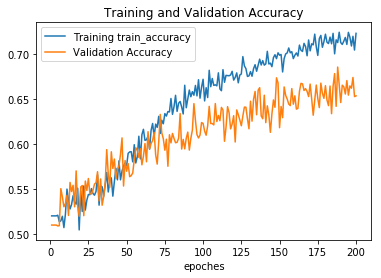

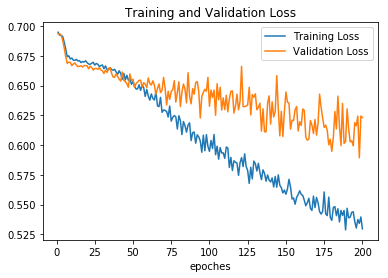

In [93]:
log_interval = 1
dianostic_plots(train_acc_list[::log_interval], train_loss_list[::log_interval], val_acc_list, val_loss_list)

In [94]:
optimizers = {'adam': torch.optim.Adam(hybrid_net.parameters(), lr=1e-2, weight_decay=1e-3),
              'rmsprop': torch.optim.RMSprop(hybrid_net.parameters(), lr=1e-3, weight_decay=1e-4)}
config = {'epochs':100, 'device':device, 
          'opt': optimizers['adam'],
          'criterion':nn.BCELoss(),
          'batch_size': batch_size,
          'log_interval':1}
C, L = train_x[0].shape

In [95]:
hybrid_net2, train_loss_list2, val_loss_list2, train_acc_list2, val_acc_list2 = train(hybrid_net, train_dataset, val_dataset, config)

Train on 4013 samples, validate on 1003 samples
***************************************
Epoch 1: training loss 0.7204106450080872, training acc 0.600727059248555
Time: 0.5289971828460693 

[Validation loss 0.6860300153493881, validation acc 0.5447224069148936] 

***************************************
Epoch 2: training loss 0.6839852295815945, training acc 0.557689159591763
Time: 0.5323162078857422 

[Validation loss 0.6784148663282394, validation acc 0.5780127992021277] 

***************************************
Epoch 3: training loss 0.6767537780106068, training acc 0.5602589866329479
Time: 0.5297706127166748 

[Validation loss 0.6632002741098404, validation acc 0.5824426529255319] 

***************************************
Epoch 4: training loss 0.6525853388011456, training acc 0.6127675668352601
Time: 0.5639629364013672 

[Validation loss 0.6465276330709457, validation acc 0.6203374335106383] 

***************************************
Epoch 5: training loss 0.6518404670059681, trainin

***************************************
Epoch 39: training loss 0.5838910527527332, training acc 0.6818381954479769
Time: 0.5294625759124756 

[Validation loss 0.6556981950998306, validation acc 0.6058801529255319] 

***************************************
Epoch 40: training loss 0.6080941185355186, training acc 0.6550321193099711
Time: 0.5297842025756836 

[Validation loss 0.6140887588262558, validation acc 0.661860039893617] 

***************************************
Epoch 41: training loss 0.5966973658651114, training acc 0.668400582550578
Time: 0.5318350791931152 

[Validation loss 0.6502731889486313, validation acc 0.612088597074468] 

***************************************
Epoch 42: training loss 0.6021630242466927, training acc 0.6588212382586706
Time: 0.5302536487579346 

[Validation loss 0.6451455950737, validation acc 0.6342711103723404] 

***************************************
Epoch 43: training loss 0.592569638043642, training acc 0.6721995800216763
Time: 0.531903505325317

***************************************
Epoch 77: training loss 0.5522642508149147, training acc 0.7107540417268786
Time: 0.5301153659820557 

[Validation loss 0.6195018291473389, validation acc 0.6552152593085107] 

***************************************
Epoch 78: training loss 0.5689426101744175, training acc 0.6916616803648844
Time: 0.5320804119110107 

[Validation loss 0.6093684434890747, validation acc 0.6424326795212766] 

***************************************
Epoch 79: training loss 0.5730766523629427, training acc 0.6905693980310693
Time: 0.5330984592437744 

[Validation loss 0.5932280868291855, validation acc 0.6775556848404255] 

***************************************
Epoch 80: training loss 0.5964848436415195, training acc 0.6584599665823699
Time: 0.5339438915252686 

[Validation loss 0.6220986247062683, validation acc 0.634549534574468] 

***************************************
Epoch 81: training loss 0.573627969250083, training acc 0.6951487987716763
Time: 0.5295333862

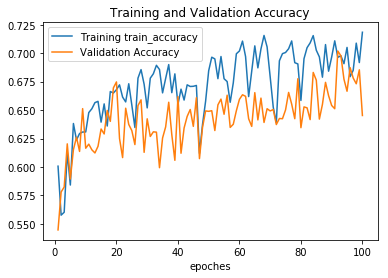

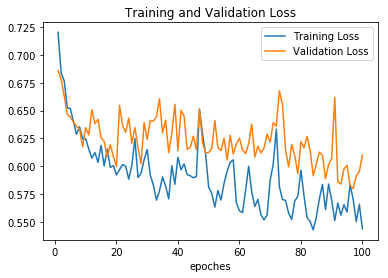

In [96]:
log_interval = 1
dianostic_plots(train_acc_list2[::log_interval], train_loss_list2[::log_interval], val_acc_list2, val_loss_list2)